In [1]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
#load ultra data base
from utils.structure import *
#from umap import UMAP

In [4]:
udb = load_structure("./data/ultradf_v4.json")
rep = pd.read_csv('signatures/reprogramming_mouse_full.csv', index_col=0)

In [4]:
#accepted datasets of signature
# datasets = ['GSE67462$OSKM','GSE38509$OSKM','GSE38509$OSK',
#         'GSE116309$OKMS', 'GSE116309$OK+9MS', 'GSE46321$C/EBPα+ OSKM', 
#         'GSE114581$OSKM+dox_mef', 'GSE21757$OKMS',
#         'GSE127927$7F-Esrrb', 'GSE127927$7F-Glis1', 'GSE127927$7F-Jdp2', 
#         'GSE127927$7F-Kdm2b', 'GSE127927$7F-Mkk6', 'GSE127927$7F-Nanog', 
#         'GSE127927$7F-Sall4', 'GSE127927$7F', 
#         'GSE102348$OSKM$Gatad2a-/-', 'GSE102348$OSKM$Mbd3f/-', 'GSE102348$OSKM$WT-1']

datasets = ['GSE89455$OSKM$HDF', 'GSE89455$OSKM$HAdMSC', 'GSE89455$OSKM$HA', 
             'GSE89455$OSKM$HBEC','GSE89455$OSKM$HPrEC','GSE50206$OSKM$HDF',
             'GSE50206$OSKM$ASC','GSE50206$OSKM$HA','GSE50206$OSKM$NHBE',
             'GSE50206$OSKM$PrEC','GSE54848$OSKM$HDF']

# Mean dynamics of dataset

In [10]:
datasets = udb.keys()

In [5]:
from functools import reduce

prelist = []
for key in datasets:
    data = udb[key]['data']
    data.columns = [key + '$$' + c for c in data.columns]
    data = data.subtract(data.mean(1), axis='rows')#.div(data.std(1), axis='rows')
    data = data.T
    data['TIME'] = udb[key]['time']
    data = data.T
    prelist.append(data)

db = reduce(lambda x,y: pd.merge(x, y, on='index', how='inner',), prelist).T

In [23]:
#db.T.iloc[:,0:2].to_csv('tmp/temp_universe.csv')

In [6]:
#create new time
interval = 1
db['pTIME'] = db['TIME'] // interval * interval
#filter from nonrepresented values
#db = db[~((db['pTIME'] == 14) | (db['pTIME'] == 16) | (db['pTIME'] == 20))]
db = db.dropna(1)

In [15]:
#pd.DataFrame(X.columns.tolist(), columns=['Entrez']).set_index('Entrez').to_csv('dynamics_components/human_universe.csv')

In [9]:
from sklearn.feature_selection import f_classif
from statsmodels.stats.multitest import multipletests

X = db.drop(['TIME', 'pTIME'], 1)
y = db['pTIME']

###create universe
#pd.DataFrame(X.columns.tolist(), columns=['Entrez']).set_index('Entrez').to_csv('dynamics_components/mouse_universe.csv')

fstat, pval = f_classif(X, y)
passed, pval_adj, *_ = multipletests(pval, alpha=1e-10, method='fdr_bh')

print(' Total: %d\n p-passed: %d\n FDR-passed: %d' % (X.shape[1], sum(pval < 0.05), sum(passed)))

 Total: 16802
 p-passed: 16163
 FDR-passed: 10529


In [10]:
new_db = X.iloc[:, passed]
new_db = new_db.div(new_db.std(1), axis='rows') #scale
new_db['pTIME'] = y
new_db['TIME'] = db['TIME']

In [11]:
avg_dynamics = new_db.drop('TIME', 1).groupby('pTIME').agg('mean').T

In [16]:
avg_dynamics.to_csv('dynamics_components/human_avg_dynamics_p10.csv')

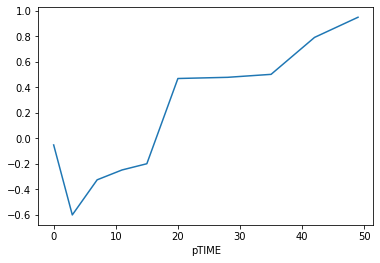

In [16]:
avg_dynamics.loc[56271].plot()#.to_csv('tmp/mouse_avg_dynamics_19ds.csv')


# Check tClock dynamics

In [58]:
avg = pd.read_csv('tmp/mouse_avg_dynamics_19ds.csv', index_col=0)
avg.index = list(map(str, avg.index.tolist()))

In [74]:
import joblib
model = joblib.load(open('clocks/Aging_mouse_norm.pkl', 'rb'))

In [75]:
genes = np.array(model.feature_names) #np.array(list(map(str, avg.index.tolist())))
wei = model.coef_
genes_ = genes[wei != 0]
wei_ = wei[wei != 0]

intsec = avg.index.intersection(genes_.tolist()).tolist()

In [76]:
avg.loc[intsec].to_csv('tmp/mouse_avg_dynamics_19ds_clock_selected.csv')

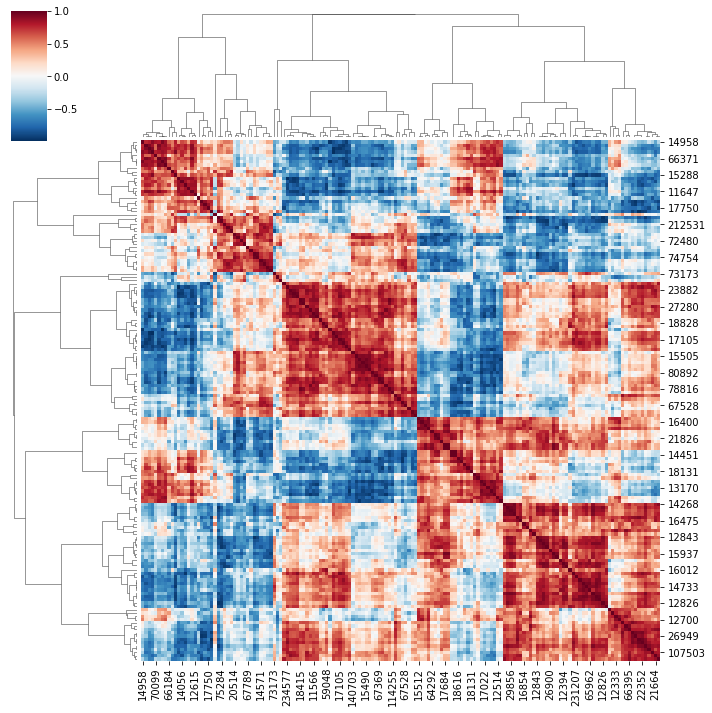

In [77]:
sns.clustermap(avg.loc[intsec].T.corr(), metric='correlation', method='complete', cmap='RdBu_r') 

# ???

In [9]:
h2m = pd.read_csv('utils/human2mouse_entrez.csv', index_col=0)

In [19]:
h2m_map = dict(zip(h2m['human'].values, h2m['mouse'].values))

In [54]:
cols = db.columns.map(h2m_map, na_action=np.nan)
cols = np.array(cols)
~np.isnan(list(cols))

array([ True,  True,  True, ..., False, False, False])

In [61]:
mouseEtz_db = db.T[~np.isnan(list(cols))].T
mouseEtz_db['TIME'] = db['TIME']

In [65]:
#mouseEtz_db.to_csv('data/human_full_data_12ds_mouse_etz.csv')

# Additional

In [59]:
df = pd.read_csv('clocks/Mouse_clock_output.csv', index_col=0)

In [60]:
tf = df

In [61]:
tf.Treatment.unique()

array(['OSKM', 'OSK', 'OK+9MS', 'C/EBPα+ OSKM', 'OSKM+dox_mef',
       '7F-Esrrb', '7F-Glis1', '7F-Jdp2', '7F-Kdm2b', '7F-Mkk6',
       '7F-Nanog', '7F-Sall4', '7F'], dtype=object)

In [62]:
tf

,ID,GEO,Treatment,Time,tAge_norm_mouseClock,tAge_scaled_mouseClock
GSE67462.OSKM.GSM1647454,GSE67462:OSKM,GSE67462,OSKM,0.0,0.152112,0.177560
GSE67462.OSKM.GSM1647455,GSE67462:OSKM,GSE67462,OSKM,0.0,0.131569,0.166540
GSE67462.OSKM.GSM1647456,GSE67462:OSKM,GSE67462,OSKM,1.0,0.108990,0.102617
GSE67462.OSKM.GSM1647457,GSE67462:OSKM,GSE67462,OSKM,1.0,0.106098,0.103676
GSE67462.OSKM.GSM1647458,GSE67462:OSKM,GSE67462,OSKM,3.0,0.072194,0.078807
...,...,...,...,...,...,...
GSE102348.OSKM.WT-1.GSM2735179,GSE102348:OSKM,GSE102348,OSKM,0.0,0.351655,0.425556
GSE102348.OSKM.WT-1.GSM2735180,GSE102348:OSKM,GSE102348,OSKM,2.0,0.395589,0.454813
GSE102348.OSKM.WT-1.GSM2735181,GSE102348:OSKM,GSE102348,OSKM,4.0,0.078564,0.154114
GSE102348.OSKM.WT-1.GSM2735182,GSE102348:OSKM,GSE102348,OSKM,6.0,0.222736,0.275356


In [63]:
import re
pattern = 'GSE\d+.(.*?).GSM'
S = tf.index.tolist()
treat = [re.search(pattern, s).group(1) for s in S]

mapper = {'OKMS':'OSKM'}
treat = [mapper[t] if t in mapper.keys() else t for t in treat ]

tf['Treatment'] = treat
tf['BatchTreatment'] = np.where(tf['Treatment'].str.contains('7F'), '7F', 'OSKM')

In [66]:
tf.to_csv('clocks/Mouse_clock_output.csv')

# PCA clustering

In [2]:
from sklearn.decomposition import PCA, KernelPCA

## zero approach

In [43]:
species = 'mouse'

#avg dymnamics
name = "%s average dynamics" % species
df = pd.read_csv('dynamics_components/%s_avg_dynamics_19ds.csv' % species, index_col=0).astype(np.float16)
#df = df.sample(500)

In [44]:
dfs = df.copy()
time = list(map(float, dfs.columns.tolist()))

features = pd.DataFrame(index = dfs.index)
for i in dfs.index:
    row = dfs.loc[i]
    dfs.loc[i] = row - row[0]

In [78]:
M = np.sqrt(1 - dfs.T.corr())

In [79]:
def PCA_sign_clustering(M, n_components=2):
    n_clusters = 2**n_components
    pca = PCA(n_components)
    Xp = pca.fit_transform(M)

    combs = np.unique([str(i) for i in np.sign(Xp)]).tolist()
    dic = {c:i for c,i in zip(combs, range(n_clusters))}

    y_pred = []
    for j in Xp:
        sig = np.sign(j)
        y_pred.append(dic[str(sig)])    
    return Xp, np.array(y_pred)

In [80]:
Xp, y_pred = PCA_sign_clustering(M, n_components=2)

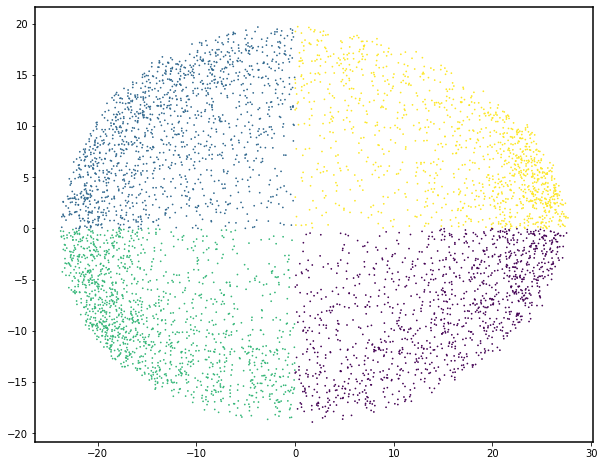

In [81]:
plt.figure(figsize=(10,8))
plt.scatter(Xp[:,0], Xp[:, 1], s=0.5, c=y_pred)

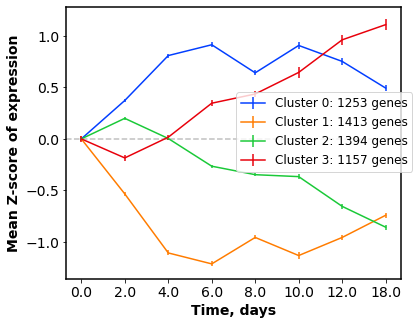

In [82]:
cluster_labels = sorted(np.unique(y_pred))
#set color palette for all plots
COLORS = list(sns.color_palette("bright"))[:len(cluster_labels)]
COLOR_DICT = dict(zip(cluster_labels, COLORS))

## cluster centroids plot
centroids = {}
plt.figure(figsize=(6,5))
plt.rcParams["axes.edgecolor"] = "0."
plt.rcParams["axes.linewidth"]  = 1.5
for i, color in COLOR_DICT.items():
    representers = df[y_pred==i]
    se = representers.sem(0)
    m = representers.mean(0)
    m = m - m.iloc[0]
    t = representers.columns
    # plt.plot(t, m, marker='o')
    centroids[i] = m
    plt.errorbar(t, m, 1.96*se, label="Cluster %d: %d genes" % (i, len(representers)), lw=1.5, color=color)

#plt.title(name + " mean representation", fontsize=14)

plt.xticks(t, fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Time, days', fontsize=14, fontweight='bold')
plt.ylabel('Mean Z-score of expression', fontsize=14, fontweight='bold')
plt.legend(fontsize=12, bbox_to_anchor=(0.49, 0.54))
plt.grid(alpha=0.)
plt.axhline(0., alpha=0.5, ls='--', color='grey')
plt.show()

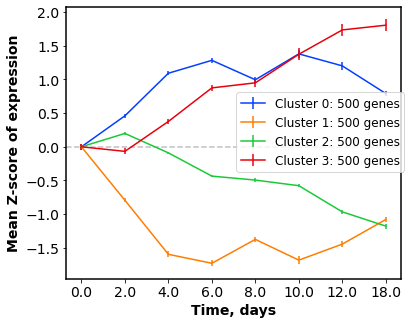

In [83]:
top = 500
#select top genes
## cluster centroids plot
centroids = {}

plt.figure(figsize=(6,5))
plt.rcParams["axes.edgecolor"] = "0."
plt.rcParams["axes.linewidth"]  = 1.5
for i, color in COLOR_DICT.items():
    representers = df[y_pred==i]
    t = representers.columns
    m = representers.mean(0)
    top_rep_ind = representers.apply(lambda x: np.corrcoef(x, m)[0,1], 1).sort_values(ascending=False)[:top].index
    top_rep = representers.loc[top_rep_ind]
    se = top_rep.sem(0)
    topm = top_rep.mean(0)
    topm = topm - topm.iloc[0]
    plt.errorbar(t, topm, 1.96*se, label="Cluster %d: %d genes" % (i, len(top_rep)), lw=1.5, color=color)

plt.xticks(t, fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Time, days', fontsize=14, fontweight='bold')
plt.ylabel('Mean Z-score of expression', fontsize=14, fontweight='bold')
plt.legend(fontsize=12, bbox_to_anchor=(0.49, 0.54))
plt.grid(alpha=0.)
plt.axhline(0., alpha=0.5, ls='--', color='grey')
plt.show()

## First approach

In [6]:
species = 'mouse'

#avg dymnamics
name = "%s average dynamics" % species
df = pd.read_csv('dynamics_components/%s_avg_dynamics_19ds.csv' % species, index_col=0).astype(np.float16)

In [119]:
dfs = df.copy()
time = list(map(float, dfs.columns.tolist()))

features = pd.DataFrame(index = dfs.index)
for i in dfs.index:
    row = dfs.loc[i]
    dfs.loc[i] = row - row[0]

features['mean'] = dfs.mean(1)
features['slope'] = dfs.apply(lambda x: np.corrcoef(x, time)[0, 1], 1)
# features['diffrange'] = dfs.apply(lambda x: np.diff(x).max() - np.diff(x).min(), 1)
# features['diffmean'] = dfs.apply(lambda x: np.mean(np.diff(x)), 1)
#features['diffslope'] = dfs.apply(lambda x: np.corrcoef(np.diff(x), time[:-1])[0,1], 1)
# features['dmean'] = features['mean'] * features['diffmean']
#features['dprod'] = features['slope'] * features['diffslope']
# features['square'] = dfs.apply(lambda x: np.corrcoef(x**2, time)[0, 1], 1)
# features['cube'] = dfs.apply(lambda x: np.corrcoef(x**3, time)[0, 1], 1)
# features['prod'] = features['mean'] * features['slope']
# features['last'] = dfs.iloc[:,-1]
# features['range'] = dfs.max(1) - dfs.min(1)

features = (features - features.mean(0)) / features.std(0)

In [120]:
features.corr()

,mean,slope,diffrange
mean,1.000000,0.564140,0.020122
slope,0.564140,1.000000,0.192642
diffrange,0.020122,0.192642,1.000000


In [94]:
features.head(3)

,mean,slope,diffmean,diffslope,dmean,dprod
index,,,,,,
11305,0.236342,0.040378,0.239929,-0.105850,-0.359757,0.033283
11363,0.962303,0.351396,0.352294,-0.932127,-0.255070,-0.182586
11364,0.690159,1.486034,0.817172,-0.185200,-0.163024,-0.245871


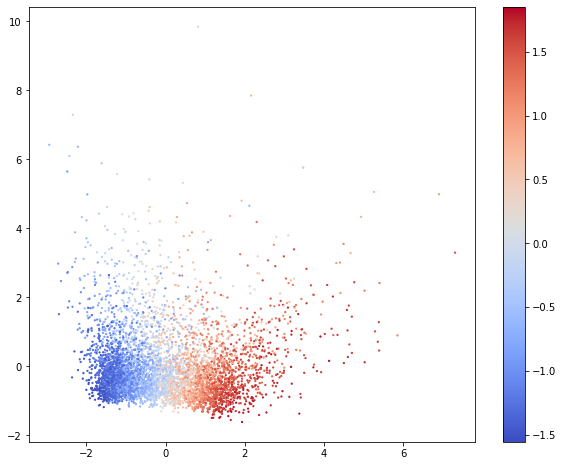

In [122]:
pca = KernelPCA(2, kernel='linear',)
Xp = pca.fit_transform(features)

plt.figure(figsize=(10,8))
plt.scatter(Xp[:,0], Xp[:, 1], s=1.5, c=features['slope'], cmap='coolwarm')
plt.colorbar()

In [22]:
tsne = MDS(2)
Xp = tsne.fit_transform(features)

plt.figure(figsize=(10,8))
plt.scatter(Xp[:,0], Xp[:, 1], s=1.2, c=dfs.mean(1), cmap='coolwarm')
plt.colorbar()

KeyboardInterrupt: 

## Second approach

In [186]:
#keys = list(udb.keys())
keys = ['GSE67462$OSKM','GSE38509$OSKM','GSE38509$OSK',
        #'GSE116309$OKMS', 'GSE116309$OK+9MS', #deleted due to the absense of 0-point
        'GSE46321$C/EBPα+ OSKM', 
        'GSE114581$OSKM+dox_mef', 'GSE21757$OKMS',
        'GSE127927$7F-Esrrb', 'GSE127927$7F-Glis1', 'GSE127927$7F-Jdp2', 
        'GSE127927$7F-Kdm2b', 'GSE127927$7F-Mkk6', 'GSE127927$7F-Nanog', 
        'GSE127927$7F-Sall4', 'GSE127927$7F', 
        'GSE102348$OSKM$Gatad2a-/-', 'GSE102348$OSKM$Mbd3f/-', 'GSE102348$OSKM$WT-1']

TIME_THRESHOLD = 8

In [190]:
udb_agg = {}
#aggregation by time replicates
times = []
for k in keys:
    data = udb[k]['data']
    time = np.round(udb[k]['time']).astype(int)
    #Filter by time points
    data_filtered = data[time <= TIME_THRESHOLD]
    time_filtered = data[time <= TIME_THRESHOLD]

    #round half-day points
    data_agg = data_filtered.T.groupby(time_filtered).mean().T
    time_agg = data_agg.columns.tolist()
    udb_agg[k] = {'data':data_agg, 'time':time_agg}
    times = times + time_agg
    #print(k, time_agg)

ValueError: Item wrong length 16 instead of 20479.

(array([17., 14.,  7., 14.,  5., 14.,  6., 11.,  7.,  0.,  1.,  2.,  3.,
         0.,  0.,  1.,  1.,  0.,  2.,  0.,  1.]),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
        13., 14., 15., 16., 17., 18., 19., 20., 21.]),
 <a list of 21 Patch objects>)

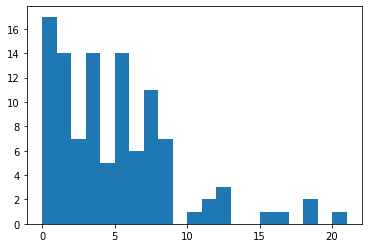

In [184]:
plt.hist(times, bins=21)

,0,1,3,5,7,11,15,18
index,,,,,,,,
11287,-0.904391,-0.953432,-0.934492,-0.890849,-0.879991,-0.938925,-0.896456,-0.912381
11298,0.441330,0.429396,0.526136,0.445078,0.486786,0.493773,0.462443,0.441023
11302,1.607004,1.543733,1.657972,1.658739,1.637089,1.616428,1.604715,1.624149
11303,0.147285,0.099053,-0.011967,0.056275,0.286263,0.281085,0.305823,0.184546
11304,-0.800365,-0.776563,-0.793607,-0.824270,-0.798421,-0.807391,-0.829711,-0.748939
...,...,...,...,...,...,...,...,...
102443351,-0.427410,-0.350055,-0.330555,-0.308838,-0.370053,-0.363512,-0.378753,-0.367245
102640923,-1.582188,-1.596461,-1.619392,-1.556490,-1.692046,-1.660525,-1.601373,-1.591198
105886298,-0.011807,0.020441,0.049097,0.044389,-0.031227,-0.048946,-0.083996,0.071541


In [123]:
#intersect all genes
db_index = udb[keys[0]]['data'].index
for k in keys:
    db_index = db_index.intersection(udb[k]['data'].index)

#create joint database
db = {}
for k in keys:
    data = udb[k]['data']
    #print(data.shape)
    norm_data = data.subtract(data.mean(0), axis='columns').div(data.std(0), axis='columns')
    norm_data = data.subtract(data.mean(0), axis='columns')
    db[k] = {'data':norm_data.loc[db_index], 'time':udb[k]['time']}

In [147]:
# independent pca
Xp_list = []
for k in keys:
    df = db[k]['data']
    pca = PCA(4, whiten=True)
    Xp = pca.fit_transform(df)
    Xp_list.append(Xp)
    print(k, np.sum(pca.explained_variance_ratio_), Xp.shape)

GSE67462$OSKM 0.9982614246285256 (7292, 4)
GSE38509$OSKM 0.9871686970736411 (7292, 4)
GSE38509$OSK 0.9960597068366602 (7292, 4)
GSE116309$OKMS 1.0 (7292, 4)
GSE116309$OK+9MS 0.9999999999999998 (7292, 4)
GSE46321$C/EBPα+ OSKM 0.9859427457822775 (7292, 4)
GSE114581$OSKM+dox_mef 0.9884948419687947 (7292, 4)
GSE21757$OKMS 0.9886294381327208 (7292, 4)
GSE127927$7F-Esrrb 0.9953190161043503 (7292, 4)
GSE127927$7F-Glis1 0.9971191434513481 (7292, 4)
GSE127927$7F-Jdp2 0.9961757896779825 (7292, 4)
GSE127927$7F-Kdm2b 0.9950443363132524 (7292, 4)
GSE127927$7F-Mkk6 0.9946504007041375 (7292, 4)
GSE127927$7F-Nanog 0.9970161738246908 (7292, 4)
GSE127927$7F-Sall4 0.997140603141508 (7292, 4)
GSE127927$7F 0.9825455389895026 (7292, 4)
GSE102348$OSKM$Gatad2a-/- 0.9848971562711787 (7292, 4)
GSE102348$OSKM$Mbd3f/- 0.9906430339436091 (7292, 4)
GSE102348$OSKM$WT-1 0.9978515843085675 (7292, 4)


In [153]:
X_ort = np.concatenate(Xp_list, 0)

Xg_df = pd.DataFrame(X_ort, columns=['pca1', 'pca2', 'pca3', 'pca4'])
Xg_df['Entrez'] = db[keys[0]]['data'].index.tolist() * n
Xgroup = Xg_df.groupby('Entrez').mean()

pca2 = PCA(2)
Xg = pca2.fit_transform(Xgroup)

In [149]:
X_ort.shape

(7292, 76)

(76, 2)


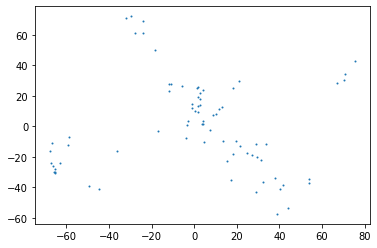

In [150]:
X_ort.shape

pca2 = PCA(2)
Xg = pca2.fit_transform(X_ort.T)
print(Xg.shape)
plt.scatter(Xg[:, 0], Xg[:, 1], s=1)

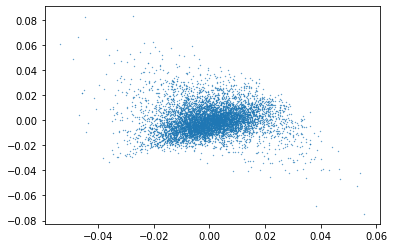

In [151]:
Xc = pca2.components_
plt.scatter(Xc[0], Xc[1], s=0.1)


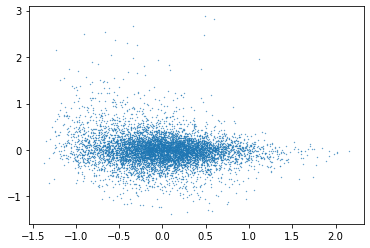

In [154]:
plt.scatter(Xgroup['pca1'], Xgroup['pca2'], s=0.1)

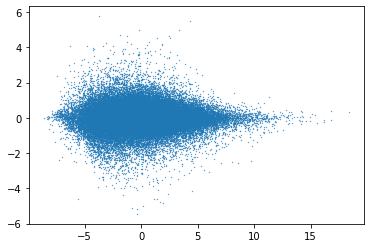

In [101]:
m = Xp.shape[0]
n = Xg.shape[0] // m

#for i in range(n):
plt.figure()
#plt.scatter(Xg[m*i:m*(i+1), 0], Xg[m*i:m*(i+1), 1], s=0.1)
plt.scatter(Xg[:, 0], Xg[:, 1], s=0.1)

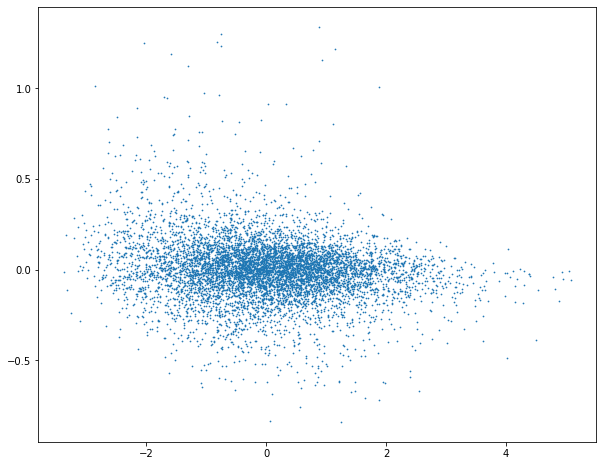

In [103]:
plt.figure(figsize=(10,8))
plt.scatter(Xgroup['pca1'], Xgroup['pca2'], s=0.5)

In [47]:
#common pca
dbdata = [db[k]['data'] for k in db.keys()]

dbdata


[           GSM1647454  GSM1647455  GSM1647456  GSM1647457  GSM1647458  \
 index                                                                   
 11303        0.145805    0.148787    0.103965    0.094157   -0.012820   
 11305       -0.065276   -0.083161   -0.095532   -0.134968    0.023226   
 11350        3.369710    3.365533    3.294260    3.291356    3.247511   
 11363        0.250925    0.258319    0.034896    0.006730    0.022467   
 11364        0.413321    0.409307    0.367872    0.358921    0.373419   
 ...               ...         ...         ...         ...         ...   
 625249       1.591921    1.600009    1.585315    1.614632    1.601123   
 641340       0.195261    0.237641    0.151569    0.120413    0.229930   
 641376      -0.082785   -0.067103   -0.084419   -0.078318   -0.088489   
 100037258    0.366533    0.371172    0.313664    0.322984    0.159963   
 100038347    0.069620    0.037193    0.171492    0.179007   -0.126761   
 
            GSM1647459  GSM1647460  

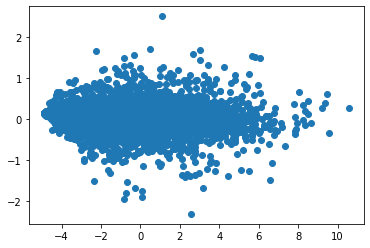

In [45]:
plt.scatter(Xp[: ,0], Xp[: ,1])

In [55]:
np.stack(Xp_list).shape

(29, 6907, 3)